# Model Predictive Control

In [1]:
#Reload IPYNB if you make changes to any of the Python files

%matplotlib inline

"""
Simulate Franka Panda Arm
"""

import numpy as np
from math import sin, cos, pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import importlib
import copy
from loadmap import loadmap
from arm_sim import simulate_arm
import robotic_arm
importlib.reload(robotic_arm)
from robotic_arm import Robot
import pickle
import random

# Weights of LQR cost
weight_R = 1
weight_Q = 10
R = weight_R*np.eye(7);
Q = weight_Q*np.eye(21)
for i in [1,2,4,5,7,8,10,11,13,14,16,17,19,20]:
    Q[i,i] = 0
Q = np.eye(21)
Qf = Q

# End time of the simulation
tf = 16

# Construct our quadrotor controller 
robotic_arm = Robot(Q, R, Qf)

## Simulate the Robotic Arm using MPC as the controller


In [2]:
x0              = np.zeros(21)
x_final         = np.zeros(21)
#####################################################################
######### ADD any random seed below to test MPC ####################
#####################################################################
random_seed1    = [0, -0.78, 0, -2.36, 0, 1.57, 0.785]
random_seed2    = [0, -0.78+0.6, 0, -2.36+0.6, 0, 1.57+np.pi/2, 0.785]

x0[0]           = random_seed1[0]
x0[3]           = random_seed1[1]
x0[6]           = random_seed1[2]
x0[9]           = random_seed1[3]
x0[12]          = random_seed1[4]
x0[15]          = random_seed1[5]
x0[18]          = random_seed1[6]

x_final[0]      = random_seed2[0]
x_final[3]      = random_seed2[1]
x_final[6]      = random_seed2[2]
x_final[9]      = random_seed2[3]
x_final[12]     = random_seed2[4]
x_final[15]     = random_seed2[5]
x_final[18]     = random_seed2[6]


x, u, t, loss, optimal_cost = simulate_arm(x0, x_final, tf, robotic_arm)

Error:  1.7504728253966269
Time step:  0.8999999999999999
 
Error:  1.4394183302506451
Time step:  1.9000000000000006
 
Error:  0.8830167307212056
Time step:  2.9000000000000012
 
Error:  0.33791773042567513
Time step:  3.900000000000002
 
Error:  0.004652161621497521
Time step:  4.899999999999999
 
Error:  0.11329504580907825
Time step:  5.899999999999995
 
Error:  0.07211025104775025
Time step:  6.8999999999999915
 
Error:  0.008459554589852146
Time step:  7.899999999999988
 
Error:  0.05651364361321795
Time step:  8.899999999999984
 
Error:  0.05570829051487769
Time step:  9.89999999999998
 
Error:  0.026516770153353787
Time step:  10.899999999999977
 


## Visualise the time taken and the drop in error as the robot moves from start to finish (if it converges)

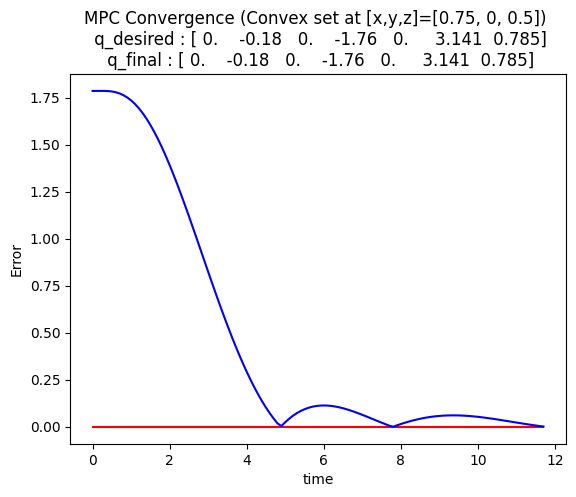

In [7]:
def visualize_error(loss, t, x_final):
    error_desired = [0]*len(loss)
    plt.title("MPC Convergence (Convex set at [x,y,z]=[0.75, 0, 0.5]) \n q_desired : {}\n q_final : {}".format(np.round(random_seed2,3), np.round(random_seed2,3)))
    plt.xlabel("time")
    plt.ylabel("Error")
    plt.plot(t[:-1], error_desired, "r-")
    plt.plot(t[:-1], loss, color='blue')
    plt.show()

visualize_error(loss,t, x_final)

## Test for robustness of MPC

In [3]:
passed_counter  = 0
passedlist      = []
failedlist      = []
initial_error   = []
final_error     = []

for i in range(100):
    print("Iteration no.: ", i)
    pass_state_dict = {}
    fail_state_dict = {}
    x0      = np.zeros(21)
    x_final = np.zeros(21)
    
    lowerLim = np.array([-2.8973, -1.7628, -2.8973, -3.0718, -2.8973, -0.0175, -2.8973])    # Lower joint limits in radians ** This does not include gripper
    upperLim = np.array([ 2.8973,  1.7628,  2.8973, -0.0698,  2.8973,  3.7525,  2.8973])    # Upper joint limits in radians (grip in mm)
    
    random_seed1 = random.uniform(lowerLim, upperLim)
    random_seed2 = random.uniform(lowerLim, upperLim)

    x0[0]   = random_seed1[0]
    x0[3]   = random_seed1[1]
    x0[6]   = random_seed1[2]
    x0[9]   = random_seed1[3]
    x0[12]  = random_seed1[4]
    x0[15]  = random_seed1[5]
    x0[18]  = random_seed1[6]

    x_final[0]  = random_seed2[0]
    x_final[3]  = random_seed2[1]
    x_final[6]  = random_seed2[2]
    x_final[9]  = random_seed2[3]
    x_final[12] = random_seed2[4]
    x_final[15] = random_seed2[5]
    x_final[18] = random_seed2[6]

    x, u, t, error_list, optimal_cost = simulate_arm(x0, x_final, tf, robotic_arm)

    print("Starting error: ",     error_list[0])
    print("Iteration end error: ",error_list[-1])
    
    initial_error   .append(np.array(error_list)[0])
    final_error     .append(np.array(error_list)[-1])
    
    if(np.array(error_list)[-1]<0.1):
        passed_counter+=1
        print("Passed")
        pass_state_dict["x0"] = x0
        pass_state_dict["x_final"] = x_final
        pass_state_dict["time_taken"] = t[-1]
        passedlist.append(pass_state_dict)
    
    else:
        print("Failed")
        fail_state_dict["x0"] = x0
        fail_state_dict["x_final"] = x_final
        fail_state_dict["time_taken"] = t[-1]
        failedlist.append(fail_state_dict)
    print(" ")
        

Iteration no.:  0
Starting error:  2.857730625474928
Iteration end error:  0.0031878199669479685
Passed
 
Iteration no.:  1
Starting error:  10.529021593991516
Iteration end error:  0.057879056223904275
Passed
 
Iteration no.:  2
Starting error:  2.330161332905016
Iteration end error:  0.0025993124603929923
Passed
 
Iteration no.:  3
Starting error:  0.01921246987238436
Iteration end error:  0.001103919175566162
Passed
 
Iteration no.:  4
Starting error:  8.411110267723368
Iteration end error:  0.04623669158099423
Passed
 
Iteration no.:  5
Starting error:  5.942136949751131
Iteration end error:  0.032664505009757275
Passed
 
Iteration no.:  6
Starting error:  1.0602033481717312
Iteration end error:  0.003874255382385823
Passed
 
Iteration no.:  7
Starting error:  0.5369931516865156
Iteration end error:  0.001962310920648497
Passed
 
Iteration no.:  8
Starting error:  7.468737670690199
Iteration end error:  0.04105637771795805
Passed
 
Iteration no.:  9
Starting error:  6.5773429951918

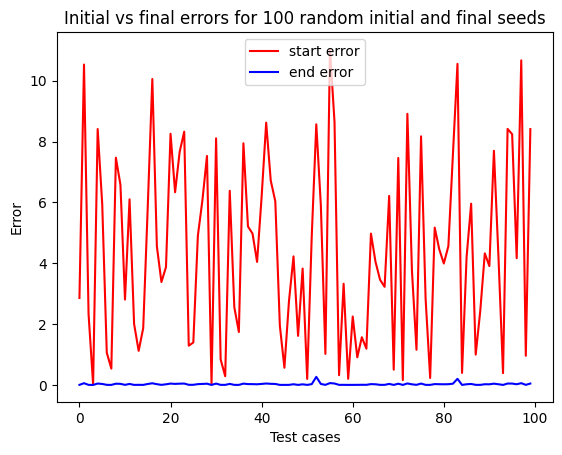

In [4]:
error_desired = [0]*len(error_list)
plt.title("Initial vs final errors for 100 random initial and final seeds")
# plt.title("".format())
plt.xlabel("Test cases")
plt.ylabel("Error")
plt.plot(initial_error, "red", label="start error")
plt.plot(final_error, color='blue', label="end error")
plt.legend(loc="best")
plt.show()

## Measured readings taken by different control algorithms to manipulate robot 

Note: The value of the follow arrays are filled in based on the computations obtained after running the rrt_mpc.py. Please visualise and run the simulation and add your results accordingly

Text(0.5, 1.0, 'Efficiency Model Predictive Control on 7-DOF Robot Arm')

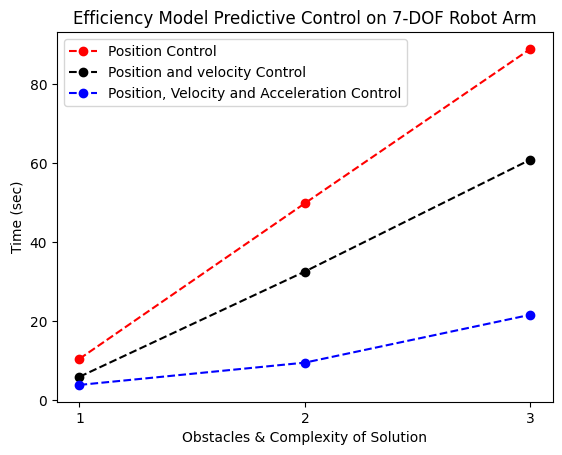

In [18]:
pos         = np.array([10.43, 49.86, 88.98])
pos_vel     = np.array([5.88,  32.56, 60.92])
pos_vel_acc = np.array([3.82,  9.47,  21.60])
y = [1,2,3]

plt.plot(y,pos,         '--o', color = 'red',   label='Position Control')
plt.plot(y,pos_vel,     '--o', color = 'black', label='Position and velocity Control')
plt.plot(y,pos_vel_acc, '--o', color = 'blue',  label='Position, Velocity and Acceleration Control')
plt.xticks(ticks=y, labels=y)

plt.legend()
plt.ylabel('Time (sec)')
plt.xlabel('Obstacles & Complexity of Solution')
plt.title('Efficiency Model Predictive Control on 7-DOF Robot Arm')



## Joint position, velocity and acceleration graphs for given obstacle map

Note: #Run this cell only after you have run rrt_mpc.py and only after visualizing and saving the results

In [13]:
state_file = 'add/your/path/here/saved_state_3'
time_taken_file = 'add/your/path/here/Time_test_file_3'

with open(state_file, 'rb') as f:
    x = pickle.load(f)
with open(time_taken_file, 'rb') as f:
    time_file = pickle.load(f)

In [14]:
#Velocity and Acceleration Limits of the Panda Robot Arm
# you can find these at their official website https://frankaemika.github.io/docs/control_parameters.html
vel_lim = np.array([2.1750, 2.1750, 2.1750, 2.1750, 2.6100, 2.6100, 2.6100])
acc_lim = np.array([15, 7.5, 10, 12.5, 15, 20, 20])

#Joint angle limits
q_max = np.array([2.8973,1.7628, 2.8973,-0.0698,2.8973,3.7525, 2.8973])
q_min = np.array([-2.8973,-1.7628, -2.8973,-3.0718, -2.8973, -0.0175, -2.8973])

In [11]:
time_file = {'position':[10]}
# time_file['position'][0] = 10

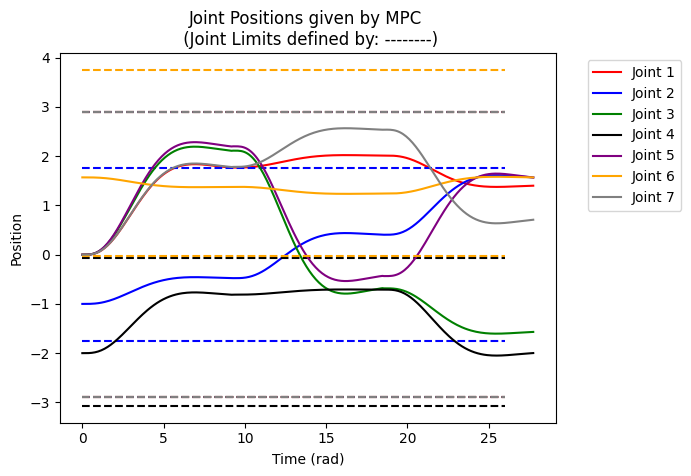

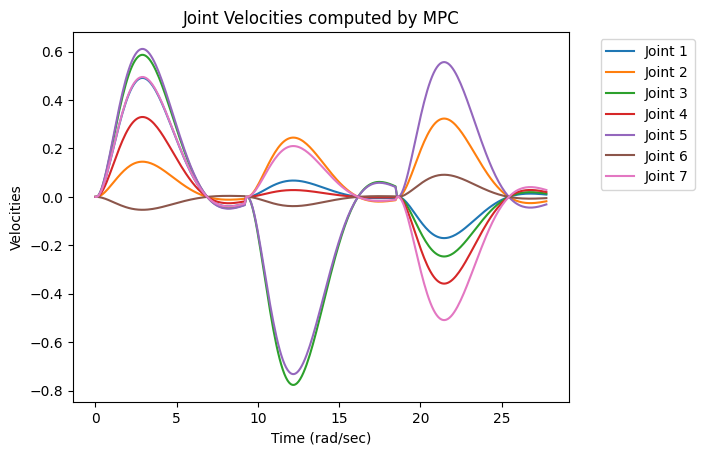

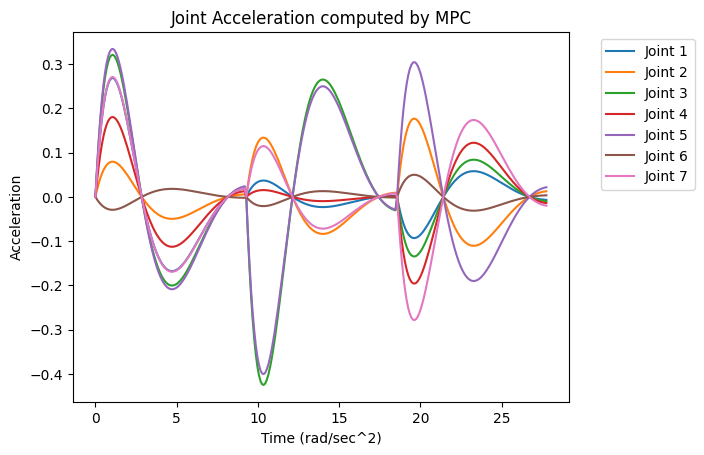

In [17]:
joint_pos_0 = [x['q'][idx][0] for idx in range(len(x['q']))]
joint_pos_1 = [x['q'][idx][1] for idx in range(len(x['q']))]
joint_pos_2 = [x['q'][idx][2] for idx in range(len(x['q']))]
joint_pos_3 = [x['q'][idx][3] for idx in range(len(x['q']))]
joint_pos_4 = [x['q'][idx][4] for idx in range(len(x['q']))]
joint_pos_5 = [x['q'][idx][5] for idx in range(len(x['q']))]
joint_pos_6 = [x['q'][idx][6] for idx in range(len(x['q']))]
time_axis = np.linspace(0, time_file['position'][0], len(x['q']))

plt.plot(time_axis, joint_pos_0, label = 'Joint 1', color = 'red')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[0], '--', color = 'red')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[0], '--', color = 'red')
plt.plot(time_axis, joint_pos_1, label = 'Joint 2', color = 'blue')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[1], '--', color = 'blue')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[1], '--', color = 'blue')
plt.plot(time_axis, joint_pos_2, label = 'Joint 3',color = 'green')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[2], '--', color = 'green')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[2], '--', color = 'green')
plt.plot(time_axis, joint_pos_3, label = 'Joint 4',color = 'black')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[3], '--', color = 'black')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[3], '--', color = 'black')
plt.plot(time_axis, joint_pos_4, label = 'Joint 5',color = 'purple')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[4], '--', color = 'purple')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[4], '--', color = 'purple')
plt.plot(time_axis, joint_pos_5, label = 'Joint 6',color = 'orange')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[5], '--', color = 'orange')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[5], '--', color = 'orange')
plt.plot(time_axis, joint_pos_6, label = 'Joint 7',color = 'grey')
plt.plot(np.ones(int(time_file['position'][0]))*q_min[6], '--', color = 'grey')
plt.plot(np.ones(int(time_file['position'][0]))*q_max[6], '--', color = 'grey')
plt.xlabel('Time (rad)')
plt.ylabel('Position')
plt.title('Joint Positions given by MPC \n (Joint Limits defined by: --------)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

joint_vel_0 = [x['qdot'][idx][0] for idx in range(len(x['q']))]
joint_vel_1 = [x['qdot'][idx][1] for idx in range(len(x['q']))]
joint_vel_2 = [x['qdot'][idx][2] for idx in range(len(x['q']))]
joint_vel_3 = [x['qdot'][idx][3] for idx in range(len(x['q']))]
joint_vel_4 = [x['qdot'][idx][4] for idx in range(len(x['q']))]
joint_vel_5 = [x['qdot'][idx][5] for idx in range(len(x['q']))]
joint_vel_6 = [x['qdot'][idx][6] for idx in range(len(x['q']))]
time_axis = np.linspace(0, time_file['position'][0], len(x['qdot']))

plt.plot(time_axis, joint_vel_0, label = 'Joint 1')
plt.plot(time_axis, joint_vel_1, label = 'Joint 2')
plt.plot(time_axis, joint_vel_2, label = 'Joint 3')
plt.plot(time_axis, joint_vel_3, label = 'Joint 4')
plt.plot(time_axis, joint_vel_4, label = 'Joint 5')
plt.plot(time_axis, joint_vel_5, label = 'Joint 6')
plt.plot(time_axis, joint_vel_6, label = 'Joint 7')
plt.xlabel('Time (rad/sec)')
plt.ylabel('Velocities')
plt.title('Joint Velocities computed by MPC')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

joint_acc_0 = [x['qddot'][idx][0] for idx in range(len(x['q']))]
joint_acc_1 = [x['qddot'][idx][1] for idx in range(len(x['q']))]
joint_acc_2 = [x['qddot'][idx][2] for idx in range(len(x['q']))]
joint_acc_3 = [x['qddot'][idx][3] for idx in range(len(x['q']))]
joint_acc_4 = [x['qddot'][idx][4] for idx in range(len(x['q']))]
joint_acc_5 = [x['qddot'][idx][5] for idx in range(len(x['q']))]
joint_acc_6 = [x['qddot'][idx][6] for idx in range(len(x['q']))]
time_axis = np.linspace(0, time_file['position'][0], len(x['qddot']))


plt.plot(time_axis, joint_acc_0, label = 'Joint 1')
plt.plot(time_axis, joint_acc_1, label = 'Joint 2')
plt.plot(time_axis, joint_acc_2, label = 'Joint 3')
plt.plot(time_axis, joint_acc_3, label = 'Joint 4')
plt.plot(time_axis, joint_acc_4, label = 'Joint 5')
plt.plot(time_axis, joint_acc_5, label = 'Joint 6')
plt.plot(time_axis, joint_acc_6, label = 'Joint 7')
plt.xlabel('Time (rad/sec^2)')
plt.ylabel('Acceleration')
plt.title('Joint Acceleration computed by MPC')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4a946460-7849-4422-942f-5a0cbbeecd65' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>